<a href="https://colab.research.google.com/github/componavt/sns4human/blob/main/src/vk/topics/zero_shot_topic_classification_ru.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔍📚 Zero-Shot Multilingual Topic Classifier

🎯 **Goal**: Automatically assign one of 24 expert-defined topics to thousands of short social media posts — without any fine-tuning!

🤖 **Model**: [`joeddav/xlm-roberta-large-xnli`](https://huggingface.co/joeddav/xlm-roberta-large-xnli) (based on XLM-RoBERTa)

🗂 **Input**: CSV file with columns:
- `text` — the post content
- `topic` — the expert-assigned label

📈 **Output**:
- `classified_posts.csv` with predicted topic and confidence score
- Evaluation metrics: `accuracy`, `precision`, `recall`, `F1-score`

🧪 Ideal for: fast prototyping of topic classification in Russian and other languages using Hugging Face's zero-shot pipeline.

⚡️ Tip: Batch-processing enabled for efficient GPU utilization.

In [1]:
# topics are indicated by an expert for each social network post
filename = '512_posts_24_topics.csv'

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Total posts after filtering: 463


Classifying posts: 100%|██████████| 58/58 [09:12<00:00,  9.53s/it]



Classification Report (Zero-Shot vs Expert Labels):
                        precision    recall  f1-score   support

         Эпос_Калевала       0.22      0.33      0.27         6
       благоустройство       0.35      0.54      0.42        13
                 вепсы       0.31      0.31      0.31        13
                 война       0.62      0.45      0.53        11
              выставка       0.53      0.82      0.64        22
день рождения и юбилей       0.65      0.57      0.60        23
             еда кухня       0.80      0.25      0.38        16
       карельский язык       0.22      0.68      0.34        19
               конкурс       0.28      0.55      0.37        20
            литература       0.15      0.17      0.16        12
   мероприятия проекты       0.29      0.10      0.15        48
      музей. экскурсия       0.17      0.05      0.07        22
                музыка       0.77      0.53      0.62        19
           образование       0.33      0.15      0

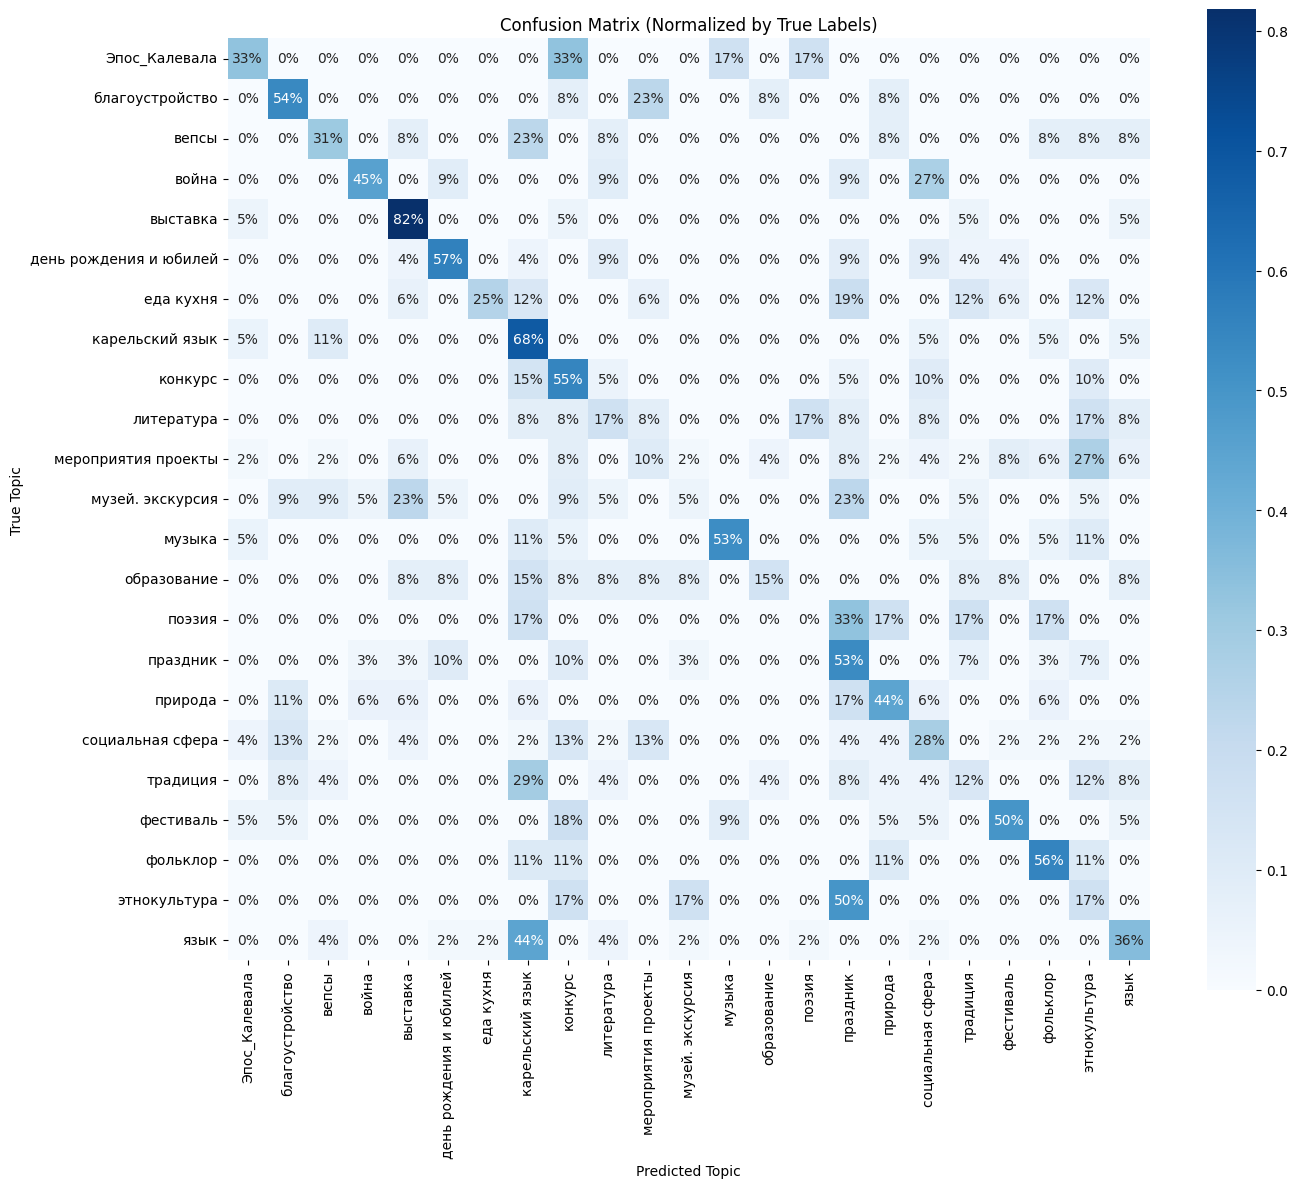

In [2]:
from transformers import pipeline
import pandas as pd
from tqdm import tqdm
from io import StringIO
import requests
from io import StringIO
import requests
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load zero-shot classification pipeline with multilingual support
classifier = pipeline("zero-shot-classification", model="joeddav/xlm-roberta-large-xnli")

# Load texts with 'text' and 'topic' columns
response = requests.get(f'https://raw.githubusercontent.com/componavt/sns4human/refs/heads/main/data/vk/topics/{filename}')
df = pd.read_csv(StringIO(response.text), delimiter=',', encoding='utf-8')

# Remove unassigned topic posts
df = df[df['topic'].str.lower() != 'пусто'].copy()

print(f"Total posts after filtering: {len(df)}")

texts       = df['text'].tolist()
true_labels = df['topic'].tolist()

# List of 24-1 topic labels defined by the expert
topic_labels = [
    "Эпос_Калевала", "благоустройство", "вепсы", "война", "выставка",
    "день рождения и юбилей", "еда кухня", "карельский язык", "конкурс",
    "литература", "мероприятия проекты", "музей. экскурсия", "музыка",
    "образование", "поэзия", "праздник", "природа", "социальная сфера",
    "традиция", "фестиваль", "фольклор", "этнокультура", "язык" #, "пусто"
]

# Store results
results = []
predicted_labels = []

# Batch processing
batch_size = 8
for i in tqdm(range(0, len(texts), batch_size), desc="Classifying posts"):
    batch = texts[i:i+batch_size]
    outputs = classifier(batch, topic_labels, multi_label=False)
    if isinstance(outputs, dict):  # if only one item
        outputs = [outputs]
    for output in outputs:
        top_label = output['labels'][0]
        confidence = output['scores'][0]
        predicted_labels.append(top_label)
        results.append({
            "text": output['sequence'],
            "predicted_topic": top_label,
            "confidence": confidence
        })

# Save to CSV
result_df = pd.DataFrame(results)
result_df['true_topic'] = true_labels
result_df.to_csv("classified_posts.csv", index=False, encoding="utf-8")

# Evaluate accuracy
print("\nClassification Report (Zero-Shot vs Expert Labels):")
print(classification_report(true_labels, predicted_labels, zero_division=0))

# Confusion matrix visualization
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=topic_labels)
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(14, 12))
sns.heatmap(conf_matrix_normalized, xticklabels=topic_labels, yticklabels=topic_labels,
            annot=True, fmt=".0%", cmap="Blues", cbar=True, square=True)
plt.title("Confusion Matrix (Normalized by True Labels)")
plt.xlabel("Predicted Topic")
plt.ylabel("True Topic")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()